##  A 1-Hidden Layer Architecture
What is happening here?
    [1] A traditional ANN model with EarlyStopping and ModelCheckpoint
    [2] Data is normalized using the centralization method
    [3] Contains two lines of code to find the rsquare
    [4] Includes lines of code on cross validation
    [5] Include the plot of the history curves

The lower value of MAE, MSE, and RMSE implies higher accuracy of a regression model. However, a higher value of R square is considered desirable.

In [20]:
import pandas as pd 
import numpy as np                                             
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score
import math
from matplotlib import pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import cross_val_score, KFold

## Imports the data
bucklingdata = pd.read_csv("CBL_SimulationResults.csv", encoding='cp1252')
input_data = bucklingdata.drop(['Critical Buckling Load (N)','Critical Buckling Load (kN)'], axis=1)
output_data = bucklingdata['Critical Buckling Load (kN)']

# Normalize each feature (column) in the input_data
normalized_input_data = preprocessing.normalize(input_data)
#print(normalized_input_data)

# Describe the output data
print(output_data.describe())

## Data splitting
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(normalized_input_data, output_data,
                                                   test_size=0.3,
                                                    shuffle=False,
                                                    stratify=None,
                                                    random_state=42)

## Train your model for a number of epochs, with the .fit()
# For validation number input and output data
val_no = round(0.2*y_train.size)
x_val = X_train[:val_no]
y_val = y_train[:val_no]

# Define model
def create_model1H(hp_layer_1):
    model = Sequential()
    model.add(Input(shape=(11,)))
    model.add(Dense(hp_layer_1, activation='relu'))
    model.add(Dense(1, activation='linear'))
    hp_learning_rate = 0.001
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=['mae'])
    return model

# Specify the number of neurons for the one hidden layer
p1 = 20

# Simple early stopping and model checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='max', verbose=1, save_best_only=True)

model = create_model1H(p1)

## Fit the training model
history = model.fit(X_train, y_train, epochs=150,
                    validation_data=(x_val, y_val),batch_size = 32, callbacks=[es, mc],
                    verbose = 0)

count    1296.000000
mean       10.244549
std         2.455021
min         6.447954
25%         8.496065
50%         9.689405
75%        11.378067
max        18.627244
Name: Critical Buckling Load (kN), dtype: float64

Epoch 1: val_loss improved from -inf to 169.57762, saving model to best_model.keras

Epoch 2: val_loss did not improve from 169.57762

Epoch 3: val_loss did not improve from 169.57762

Epoch 4: val_loss did not improve from 169.57762

Epoch 5: val_loss did not improve from 169.57762

Epoch 6: val_loss did not improve from 169.57762

Epoch 7: val_loss did not improve from 169.57762

Epoch 8: val_loss did not improve from 169.57762

Epoch 9: val_loss did not improve from 169.57762

Epoch 10: val_loss did not improve from 169.57762

Epoch 11: val_loss did not improve from 169.57762

Epoch 12: val_loss did not improve from 169.57762

Epoch 13: val_loss did not improve from 169.57762

Epoch 14: val_loss did not improve from 169.57762

Epoch 15: val_loss did not improve from 1

## Get the performance metrics for the network and the learning curves

In [21]:
## Evaluating the model
trainmse, trainmae = model.evaluate(X_train, y_train, verbose=0)
valmse, valmae = model.evaluate(x_val, y_val, verbose=0)
testmse, testmae = model.evaluate(X_test, y_test, verbose=0)

# Capture the Rsquare data: training
train_pred = model.predict(X_train)
train_r2= r2_score(y_train, train_pred)

# Capture the Rsquare data: validation
val_pred = model.predict(x_val)
val_r2= r2_score(y_val, val_pred)

# Capture the Rsquare data: testing
test_pred = model.predict(X_test)
test_r2= r2_score(y_test, test_pred)

rsquares = pd.DataFrame(data = np.column_stack((train_r2, val_r2, test_r2)))
RMSEs = pd.DataFrame(data = np.column_stack((math.sqrt(trainmse), math.sqrt(valmse), math.sqrt(testmse))))
MAEs = pd.DataFrame(data = np.column_stack((trainmae, valmae, testmae)))

print(rsquares)
print(RMSEs)
print(MAEs)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
         0         1         2
0  0.30173 -0.039459 -1.397125
          0         1         2
0  2.041701  2.533656  1.713107
          0         1         2
0  1.588918  1.880008  1.404273


### loss vs the number of epochs & MAE vs the number of epochs

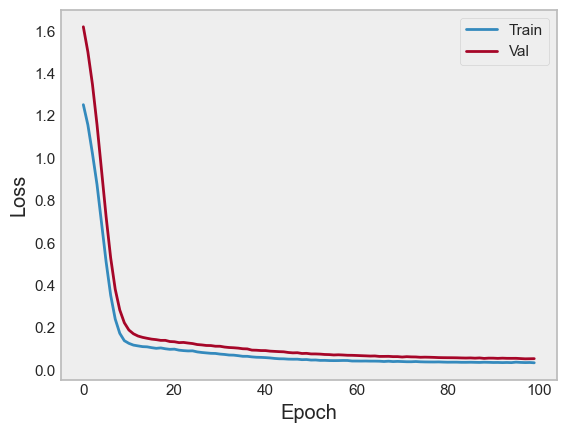

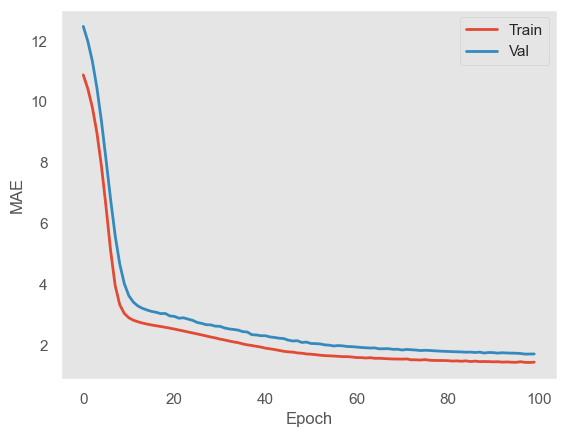

In [11]:
## Plotting Loss and MAE During Training
def plot_loss(loss,val_loss):
  plt.figure()
  plt.style.use('bmh')
  plt.grid(False)
  plt.plot(loss, linewidth=2)
  plt.plot(val_loss, linewidth=2)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

def plot_mae(mae,val_mae):
  plt.figure()
  plt.style.use('ggplot')
  plt.grid(False)
  plt.plot(mae, linewidth=2)
  plt.plot(val_mae, linewidth=2)
  plt.ylabel('MAE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

train_loss = (np.array(history.history["loss"]))/100
val_loss = np.array((history.history["val_loss"]))/100

plot_loss(train_loss, val_loss)
plot_mae(history.history["mae"], history.history["val_mae"])

### Correlation between the actual output and the predicted output with the training dataset

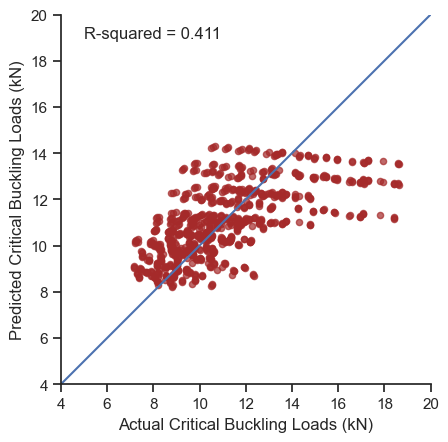

In [12]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
a = plt.axes(aspect='equal')
plt.scatter(y_train, train_pred, s = 20, alpha=0.7, c = 'brown')
plt.xlabel('Actual Critical Buckling Loads (kN)')
plt.ylabel('Predicted Critical Buckling Loads (kN)')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_train, train_pred)), (5, 19))
plt.xlim([4, 20])
plt.ylim([4, 20])
plt.plot([4, 20], [4, 20])
plt.plot()
plt.savefig('testing1.png')

### Correlation between the actual output and the predicted output with the testing dataset

[]

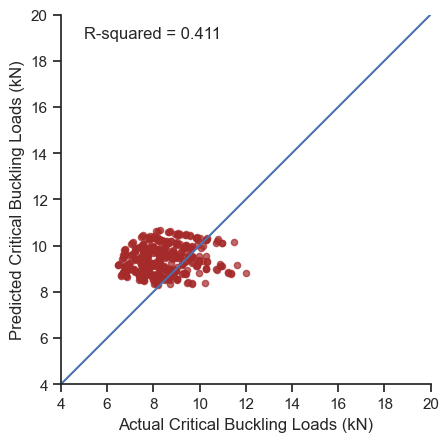

In [13]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_pred, s = 20, alpha=0.7, c = 'brown')
plt.xlabel('Actual Critical Buckling Loads (kN)')
plt.ylabel('Predicted Critical Buckling Loads (kN)')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_train, train_pred)), (5, 19))
plt.xlim([4, 20])
plt.ylim([4, 20])
plt.plot([4, 20], [4, 20])
plt.plot()

## Variable importance SHAP plot

  0%|          | 0/389 [00:00<?, ?it/s]

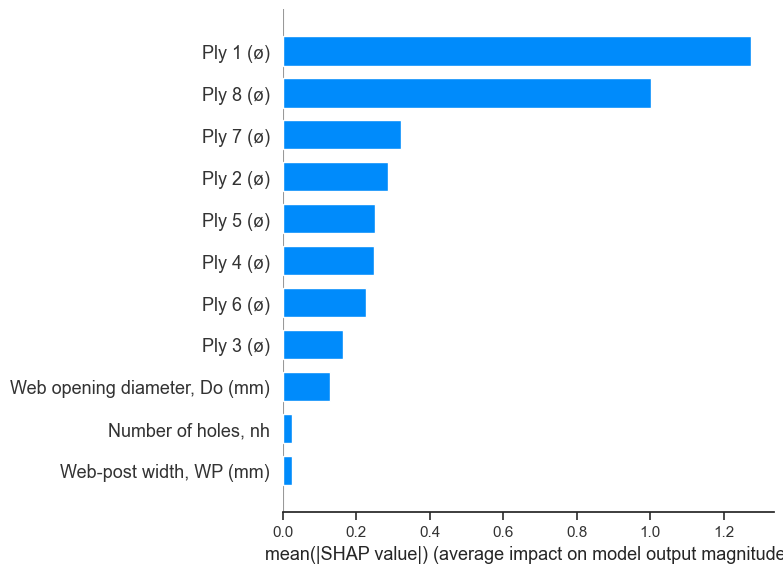

In [14]:
### VARIABLE IMPORTANCE
# See more here: https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/plots/bar.html
features = ["Number of holes, nh", "Web-post width, WP (mm)",  "Web opening diameter, Do (mm)",  "Ply 1 (ø)", "Ply 2 (ø)", "Ply 3 (ø)", "Ply 4 (ø)", "Ply 5 (ø)", "Ply 6 (ø)", "Ply 7 (ø)", "Ply 8 (ø)"]

# Create a SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(model, shap.sample(X_train, 5))

# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# Reshape shap_values to remove the last dimension
shap_values_reshaped = shap_values.reshape(X_test.shape)  # Assuming X_test.shape is (389, 11)

shap.summary_plot(shap_values_reshaped, X_test, feature_names=features, plot_type="bar")
plt.show()